# STATS 604: Gene expression in the Brain
## Team Members: Ben Agyare, Yumeng Wang, Jake Trauger, Yash Patel

## Code Setup
We start simply by loading in the data and organizing properties of subsequent interest.

In [135]:
import pickle
import copy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import collections
import os
from scipy.ndimage.filters import gaussian_filter
import cv2
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

In [136]:
with open("data/brain.pkl", "rb") as f:
    dataset = pickle.load(f)

In [137]:
expression = dataset["expression"]
genes = dataset["genes"]
samples = dataset["samples"]

## Normalization
We need to do some normalization with the bacterial spike-ins. According to the following two sources:
- https://support.bioconductor.org/p/49150/
- https://bioinformatics.mdanderson.org/MicroarrayCourse/Lectures/ma07b.pdf
two common normalization techniques are spike-in normalizatio and quantile normalization. The former doesn't really involve much assumption beyond the experimental consistency of spike-in amounts. Given that this itself could vary across labs, we should verify this behavior prior to applying spike-in normalization. Quantile normalization assumes that most genes are *not* differentially expressed (that only a handful are). 

### Spike-In Normalization
Let's start by looking at the plausibility of this spike-in normalization technique.

In [314]:
nan_genes = genes[genes["chrom"].isna()].index.values # genes not associated with chromosomes
control_genes = [gene for gene in nan_genes if gene.startswith("AFFX")]
human_genes = [gene for gene in genes.index.values if gene not in control_genes]
print(control_genes)

['AFFX-BioB-3_at', 'AFFX-BioB-3_st', 'AFFX-BioB-5_at', 'AFFX-BioB-5_st', 'AFFX-BioB-M_at', 'AFFX-BioB-M_st', 'AFFX-BioC-3_at', 'AFFX-BioC-3_st', 'AFFX-BioC-5_at', 'AFFX-BioC-5_st', 'AFFX-BioDn-3_st', 'AFFX-BioDn-5_at', 'AFFX-BioDn-5_st', 'AFFX-CreX-3_at', 'AFFX-CreX-3_st', 'AFFX-CreX-5_at', 'AFFX-CreX-5_st', 'AFFX-DapX-3_at', 'AFFX-DapX-5_at', 'AFFX-DapX-M_at', 'AFFX-HUMRGE/M10098_3_at', 'AFFX-HUMRGE/M10098_5_at', 'AFFX-HUMRGE/M10098_M_at', 'AFFX-LysX-3_at', 'AFFX-LysX-5_at', 'AFFX-LysX-M_at', 'AFFX-M27830_3_at', 'AFFX-M27830_5_at', 'AFFX-M27830_M_at', 'AFFX-MurFAS_at', 'AFFX-MurIL10_at', 'AFFX-MurIL2_at', 'AFFX-MurIL4_at', 'AFFX-PheX-3_at', 'AFFX-PheX-5_at', 'AFFX-PheX-M_at', 'AFFX-ThrX-3_at', 'AFFX-ThrX-5_at', 'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at', 'AFFX-TrpnX-5_at', 'AFFX-TrpnX-M_at', 'AFFX-YEL002c/WBP1_at', 'AFFX-YEL018w/_at', 'AFFX-YEL021w/URA3_at', 'AFFX-YEL024w/RIP1_at', 'AFFX-hum_alu_at']


In [139]:
lab_names = ["Davis", "Michigan", "Irvine"]
lab_to_data = {}
for lab in lab_names:
    lab_patients = samples[samples["lab"] == lab].index
    lab_to_data[lab] = expression.loc[lab_patients]

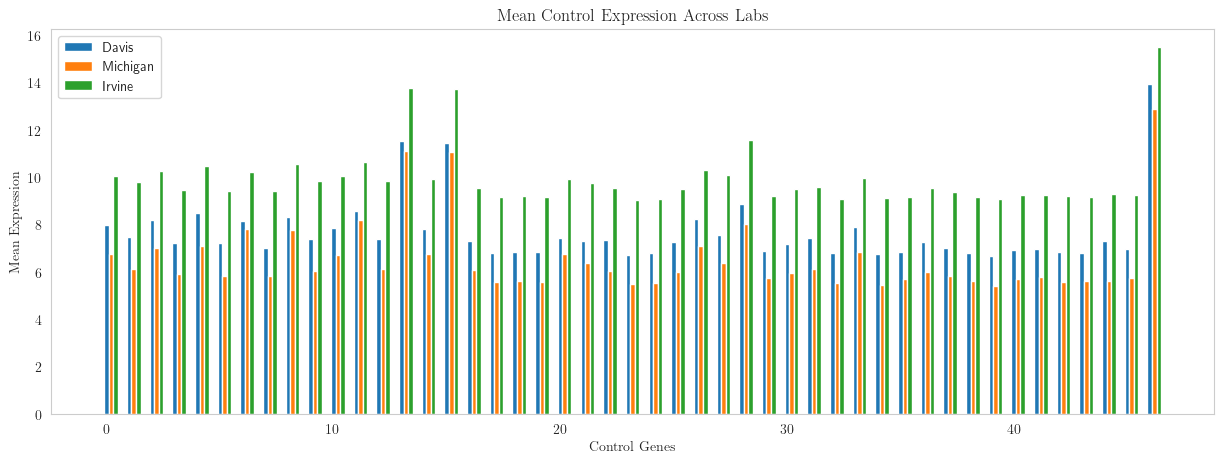

In [140]:
control_gene_vals = []
for lab in lab_names:
    lab_controls = [lab_to_data[lab][control_gene].mean() for control_gene in control_genes]
    control_gene_vals.append(lab_controls)

N = len(control_genes)
ind = np.arange(N)
plt.figure(figsize=(15,5))
width = 0.6

for i in range(3):
    plt.bar(ind + i * width / 3, control_gene_vals[i] , width / 3, label=lab_names[i])

plt.xlabel(r"$\mathrm{Control \ Genes}$")
plt.ylabel(r"$\mathrm{Mean \ Expression}$")
plt.title(r"$\mathrm{Mean \ Control \ Expression \ Across \ Labs}$")

plt.legend(loc='best')
plt.show()

Normalization purely on the spike-in data seems like it may not be fully justified, given that the Irvine lab seems to have a systematically higher control spike count than the rest. It seems unlikely that they got all chips that were more highly expressed, so this seems more likely to have been caused by differences in how the experimenters ran the tests.

We should, therefore, restrict the normalization to *each lab* separately (and similarly do so for the analysis). Let's ensure that at least this is reasonable.

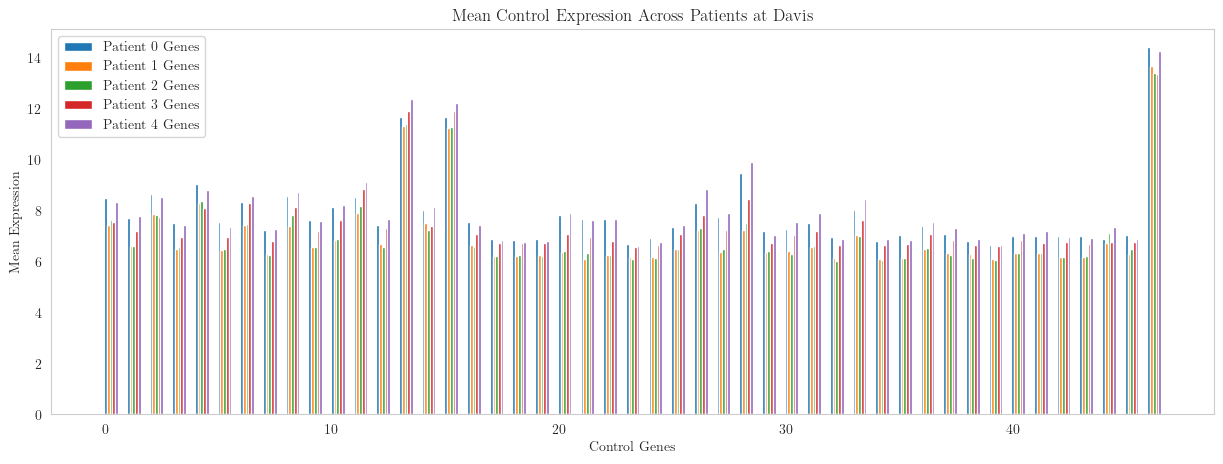

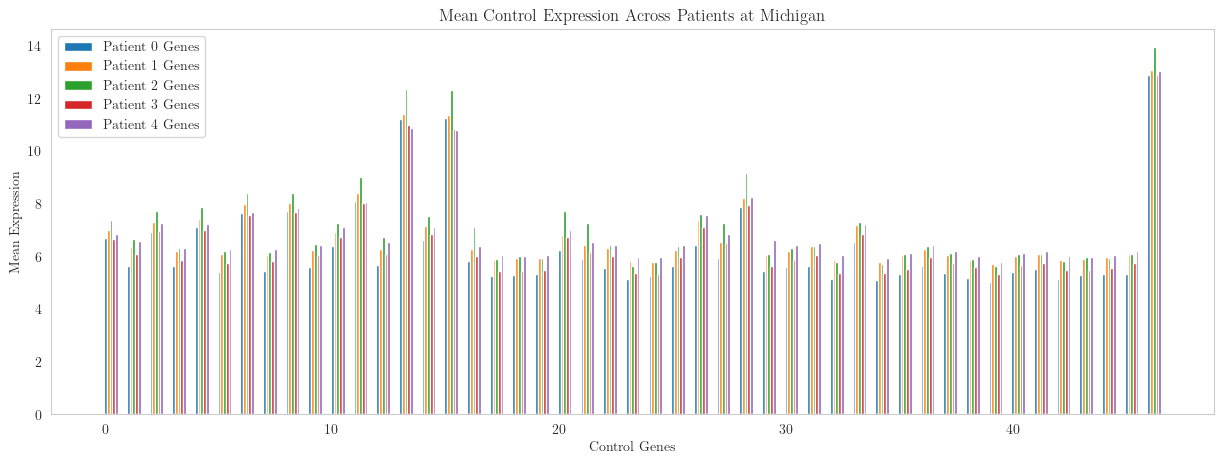

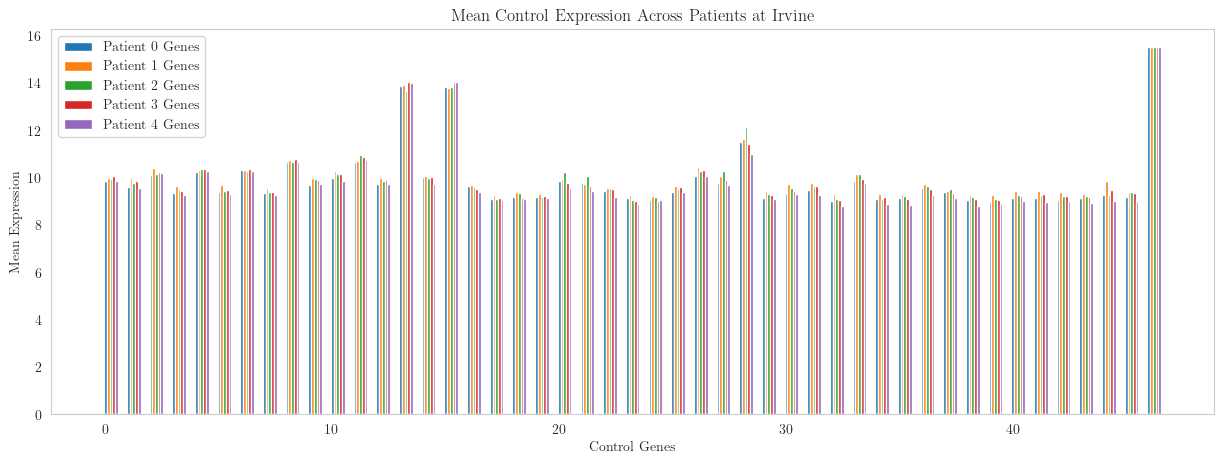

In [141]:
control_gene_vals = []

# arbitrarily display 5 patients per lab to assess plausibility of normalizing
k_patients = 5
for lab_name in lab_names:
    lab_controls_T = [lab_to_data[lab_name][control_gene][:k_patients] for control_gene in control_genes]
    lab_controls = list(map(list, zip(*lab_controls_T)))

    N = len(control_genes)
    ind = np.arange(N)
    plt.figure(figsize=(15,5))
    width = 0.6

    for i in range(k_patients):
        plt.bar(ind + i * width / k_patients, lab_controls[i] , width / k_patients, label=r"$\mathrm{Patient \ " + str(i) + r" \ Genes}$")

    plt.xlabel(r"$\mathrm{Control \ Genes}$")
    plt.ylabel(r"$\mathrm{Mean \ Expression}$")
    plt.title(r"$\mathrm{Mean \ Control \ Expression \ Across \ Patients \ at \ " + lab_name + r"}$")

    plt.legend(loc='best')
    plt.show()

Given the consistency of the spike in *per lab*, however, it seems plausible to actually go ahead with this spike-in normalization. To do so, we count gene expressed in a "normalized space" based on the total amount of control genes expressed:

$$ \widehat{g} = \frac{g}{\frac{1}{|\{c_g\}|} \sum {c_g}} $$

Where $g$ is some gene of interest and $c_g$ the set of controls.

In [147]:
lab_to_normalized_data = {}
for lab in lab_names:
    row_means = lab_to_data[lab][control_genes].mean(axis=1)
    normalized = lab_to_data[lab].div(row_means, axis=0)
    lab_to_normalized_data[lab] = normalized

print(lab_to_normalized_data["Michigan"][control_genes].sum(axis=1)) # confirm proper normalization

rownames
01_a_M_f_1.CEL    47.0
01_c_M_f_1.CEL    47.0
01_d_M_f_1.CEL    47.0
02_a_M_m_1.CEL    47.0
02_c_M_m_1.CEL    47.0
02_d_M_m_1.CEL    47.0
03_a_M_f_1.CEL    47.0
03_c_M_f_1.CEL    47.0
03_d_M_f_1.CEL    47.0
04_a_M_m_1.CEL    47.0
04_c_M_m_1.CEL    47.0
04_d_M_m_1.CEL    47.0
05_a_M_m_1.CEL    47.0
05_c_M_m_1.CEL    47.0
05_d_M_m_2.CEL    47.0
06_a_M_m_1.CEL    47.0
06_c_M_m_1.CEL    47.0
06_d_M_m_2.CEL    47.0
07_a_M_f_1.CEL    47.0
07_c_M_f_1.CEL    47.0
07_d_M_f_2.CEL    47.0
08_a_M_f_1.CEL    47.0
08_c_M_f_1.CEL    47.0
08_d_M_f_2.CEL    47.0
09_a_M_m_1.CEL    47.0
09_c_M_m_1.CEL    47.0
09_d_M_m_2.CEL    47.0
10_a_M_f_1.CEL    47.0
10_c_M_f_1.CEL    47.0
10_d_M_f_2.CEL    47.0
dtype: float64


### Getting Bearings
Let's get our bearings on what we should expect to see for a "significant difference" between males and females. As noted, genes on the Y chromosome are to be differentially expressed by males over females and therefore should serve as a way guide of what scale a "notable difference" may look like.

In [148]:
y_genes = genes[genes["chrom"] == "Y"].index.values # genes associated with Y chromosome
print(y_genes)

['31411_at' '31534_at' '31911_at' '32864_at' '32930_f_at' '32991_f_at'
 '34477_at' '35885_at' '35929_s_at' '36321_at' '37583_at' '38182_at'
 '38355_at' '40030_at' '40097_at' '41214_at']


In [149]:
michigan = lab_to_normalized_data["Michigan"]
michigan_split = {}
for gender in ["male", "female"]:
    gender_patients = samples[np.logical_and(samples["sex"] == gender, samples["lab"] == "Michigan")].index
    michigan_split[gender] = michigan.loc[gender_patients]

In [150]:
male_y = michigan_split["male"][y_genes]
female_y = michigan_split["female"][y_genes]

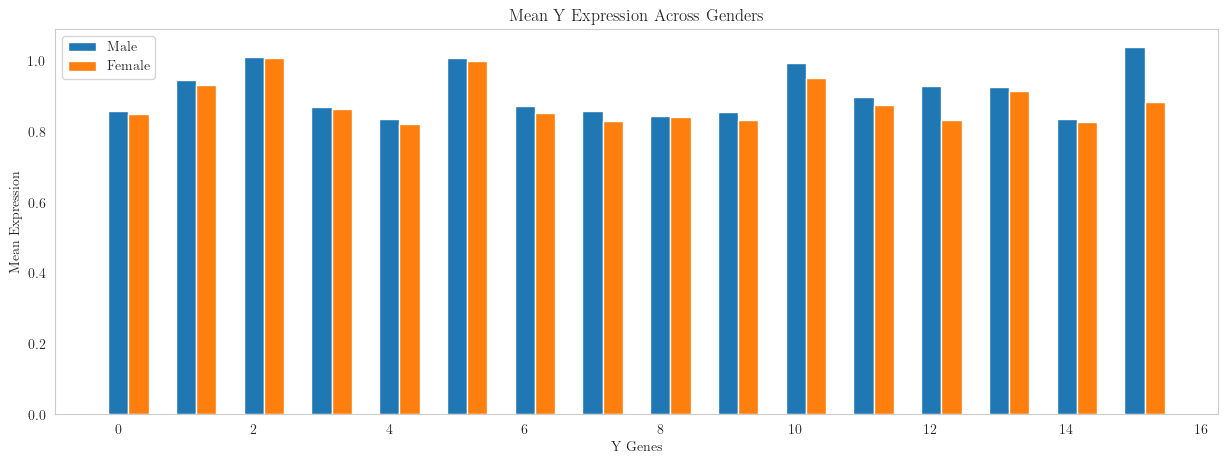

In [151]:
mean_male_y = male_y.mean(axis=0)
mean_female_y = female_y.mean(axis=0)

N = len(y_genes)
ind = np.arange(N)
plt.figure(figsize=(15,5))
width = 0.6

plt.bar(ind, mean_male_y , width / 2, label=r"$\mathrm{Male}$")
plt.bar(ind + width / 2, mean_female_y , width / 2, label=r"$\mathrm{Female}$")

plt.xlabel(r"$\mathrm{Y \ Genes}$")
plt.ylabel(r"$\mathrm{Mean \ Expression}$")
plt.title(r"$\mathrm{Mean \ Y \ Expression \ Across \ Genders}$")

plt.legend(loc='best')
plt.show()

Shockingly similar expressions for many of these. Unclear why?

## Investigating Combining Versions
We can perform this analysis in two ways: take the labs separately and treat them as separate experiments for the analysis. Or combine them and do the analysis on this combined dataset. The rationale behind the latter is to view the measurements of each labs as noisy representations of the "true" gene expressions. Before doing so, one thing that differed between otherwise seeming "replicates" of samples between labs was the version of the chip that was used. We first wish to investigate if there is any systematic difference between the versions by visualizing paired samples (i.e. samples that are otherwise replicates) after projecting them to a lower dimensional space via PCA.

In [153]:
michigan = lab_to_normalized_data["Michigan"]
davis = lab_to_normalized_data["Davis"]
irvine = lab_to_normalized_data["Irvine"]

In [195]:
v1_samples = samples[samples["chip.version"] == "v1"]
v2_samples = samples[samples["chip.version"] == "v2"]

In [262]:
# WARNING: very inscrutable code ahead: this is to basically "tie together" the patients into tuples (which is annoyingly complicated
# cause some of the data were dropped from the Irvine lab)

patient_ids = [f"patient_{str(patient_idx).rjust(2, '0')}" for patient_idx in range(1, 11)]

lab_tuple_labels = set(["Davis", "Irvine", "Michigan"])
patient_id_tuples = {}

for patient_id in patient_ids:
    patient_samples = samples[samples["patient"] == patient_id]
    
    cur_tuple_labels = copy.deepcopy(lab_tuple_labels)
    cur_patient_tuple = []
    
    patient_tuples = []
    for _, patient_sample in patient_samples.iterrows():  
        if patient_sample["lab"] not in cur_tuple_labels:
            patient_tuples.append(cur_patient_tuple)
            cur_tuple_labels = copy.deepcopy(lab_tuple_labels)
            cur_patient_tuple = []
        
        cur_tuple_labels.remove(patient_sample["lab"])
        cur_patient_tuple.append(patient_sample)
    if len(cur_patient_tuple) > 0:
        patient_tuples.append(cur_patient_tuple)
    patient_id_tuples[patient_id] = patient_tuples

In [286]:
v1_data, v2_data = [], []
for patient_id in patient_id_tuples:
    for paired_tuples in patient_id_tuples[patient_id]:
        v1_subset, v2_subset = [], []
        for sample in paired_tuples:
            if sample["chip.version"] == "v1":
                v1_subset.append(sample)
            else:
                v2_subset.append(sample)
        v1_data.append(v1_subset)
        v2_data.append(v2_subset)

In [323]:
from sklearn.decomposition import PCA

In [335]:
lab_to_reduced_data = {}
for lab in lab_to_normalized_data:
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(lab_to_normalized_data[lab][human_genes].values)
    lab_to_reduced_data[lab] = pd.DataFrame(reduced_data, columns = ['pc1','pc2'], index = lab_to_normalized_data[lab].index)

Text(0.5, 1.0, '$\\mathrm{PCs \\ For \\ V1 \\ vs \\ V2 \\ Samples}$')

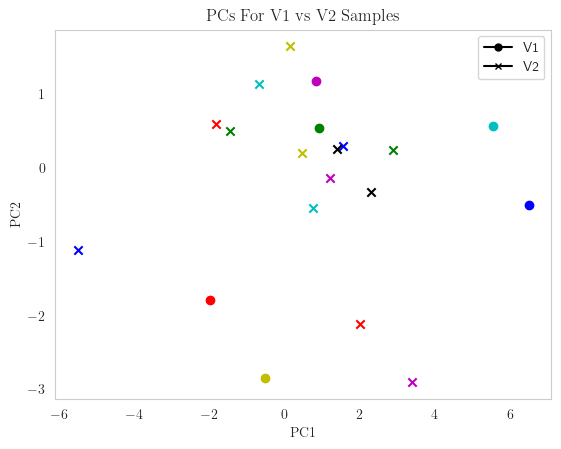

In [345]:
colors = ["b","g","r","c","m","y","k","w"]
for i, (v1_samples, v2_samples) in enumerate(zip(v1_data[8:16], v2_data[8:16])):    
    for v1_sample in v1_samples:
        x, y = lab_to_reduced_data[v1_sample["lab"]].loc[v1_sample.name]
        plt.scatter(x, y, color=colors[i], marker="o")
    for v2_sample in v2_samples:
        x, y = lab_to_reduced_data[v2_sample["lab"]].loc[v2_sample.name]
        plt.scatter(x, y, color=colors[i], marker="x")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='k', markersize=5, label='V1'),
    Line2D([0], [0], marker='x', color='k', markersize=5, label='V2'),
]
plt.legend(handles=legend_elements)

plt.xlabel(r"$\mathrm{PC1}$")
plt.ylabel(r"$\mathrm{PC2}$")
plt.title(r"$\mathrm{PCs \ For \ V1 \ vs \ V2 \ Samples}$")

This plot suggests that there are no systematic differences between the two version, which suggests that combining the samples is reasonable.

## Combined Analysis
We combine these (just with an average) and do basic differential expression analysis now.

In [453]:
# ACC, cerebellum, DLPF -- order for entries of each one
patient_averaged_samples = {}

for patient_id in patient_id_tuples:
    patient_averaged_samples[patient_id] = []
    for paired_tuples in patient_id_tuples[patient_id]:
        sample_rows = np.array([lab_to_normalized_data[sample["lab"]].loc[sample.name] for sample in paired_tuples])
        avg_sample = np.mean(sample_rows, axis=0)
        patient_averaged_samples[patient_id].append(avg_sample)
    patient_averaged_samples[patient_id] = np.array(patient_averaged_samples[patient_id])

In [454]:
male_patients_ids = set(samples[samples["sex"] == "male"]["patient"])
female_patients_ids = set(samples[samples["sex"] == "female"]["patient"])

male_patients = dict((k, patient_averaged_samples[k]) for k in male_patients_ids)
female_patients = dict((k, patient_averaged_samples[k]) for k in female_patients_ids)

In [461]:
import statsmodels
import scipy

for i, brain_region in enumerate(["ACC", "Cerebellum", "DLPF"]):
    male_accs = np.array([male_patients[patient][i] for patient in male_patients])
    female_accs = np.array([female_patients[patient][i] for patient in female_patients])

    pvalues = scipy.stats.ttest_ind(male_accs, female_accs).pvalue
    fdr_pvalues = statsmodels.stats.multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh')
    significant = np.where(fdr_pvalues[0])
    ref_columns = lab_to_normalized_data["Michigan"].columns.values
    
    print(f"{brain_region}: {ref_columns[significant[0]]}")

ACC: ['38355_at' '41214_at']
Cerebellum: ['41214_at']
DLPF: []
